# Group comparison

The group comparison was conducted to investigate three main research questions through different comparative axes:
- Non-converters vs. Converters
- Non-converters vs. Converters vs. First Episode Psychosis
- Non-converters vs. Converters vs. Schizophrenia vs. Bipolar Disorder  

These axes were selected to address the following questions:
- Are significant differences present between converters and non-converters?
- If significant differences exist, how do converters compare to individuals at the next stage of disease development, specifically those experiencing their first episode of psychosis (FEP)?
- Within the FEP group, are significant differences observed between patients with schizophrenia and those with bipolar disorder?

In [2]:
# Import libraries
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# set seaborn style
sns.set_style('whitegrid')

In [3]:
# Load data
df = pd.read_csv('../results/uncertain_merged_all_cnv_annotations_filtered_per_ind_with_clinical.csv')

# Remove outliers with ID S36958 and S36981
df = df[df['ID'] != 'S36958']
df = df[df['ID'] != 'S36981']

In [4]:
# Define constants
DESCRIPTORS = [
       'Brain_rare_length_DEL', 'Brain_rare_length_DUP',
       'Long_brain_rare_length_DEL', 'Long_brain_rare_length_DUP',
       'Long_only_brain_rare_length_DEL', 'Long_only_brain_rare_length_DUP',
       'Long_rare_length_DEL', 'Long_rare_length_DUP',
       'NB_brain_genes_rare_DEL', 'NB_brain_genes_rare_DUP',
       'NB_brain_rare_DEL', 'NB_brain_rare_DUP',
       'NB_dosage_sensitive_genes_rare_DEL', 'NB_dosage_sensitive_genes_rare_DUP',
       'NB_long_brain_rare_DEL', 'NB_long_brain_rare_DUP',
       'NB_long_only_brain_rare_DEL', 'NB_long_only_brain_rare_DUP',
       'NB_long_rare_DEL', 'NB_long_rare_DUP',
       'NB_only_brain_genes_rare_DEL', 'NB_only_brain_genes_rare_DUP',
       'NB_only_brain_rare_DEL', 'NB_only_brain_rare_DUP',
       'NB_protein_coding_genes_rare_DEL', 'NB_protein_coding_genes_rare_DUP',
       'NB_rare_DEL', 'NB_rare_DUP',
       'Only_brain_rare_length_DEL', 'Only_brain_rare_length_DUP',
       'Rare_length_DEL', 'Rare_length_DUP'
]

NUM_PLOTS = len(DESCRIPTORS)
NUM_COLS = 2
NUM_ROWS = (NUM_PLOTS // NUM_COLS) + (NUM_PLOTS % NUM_COLS)

In [5]:
# Function to filter the DataFrame based on phenotypes
def filter_df(df, phenotypes, col_name="Phenotype_1"):
    df["Phenotype"] = df[col_name].apply(lambda x: x if x in phenotypes[:-1] else phenotypes[-1])
    return df[df["Phenotype"].isin(phenotypes)]

# Function to generate colors for plots
def get_colors(phenotypes):
    color_palette = ['#bfd1df', '#8fa6c1', '#4c719e', '#3d5180']
    return dict(zip(phenotypes, color_palette))

# Function to compute p-values for each descriptor and phenotype pair
def compute_pvalues(df, pairs):
    raw_pvals = []
    descs = []
    comps = []

    for desc in DESCRIPTORS:
        for pair in pairs:
            group1 = df[df["Phenotype"] == pair[0]][desc]
            group2 = df[df["Phenotype"] == pair[1]][desc]
            _, pval = mannwhitneyu(group1, group2, alternative='two-sided')
            raw_pvals.append(pval)
            descs.append(desc)
            comps.append(pair)

    # Apply global BH correction
    _, corrected_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

    # Create dictionary of raw and corrected p-values
    pval_dict = {
        (desc, pair): (raw, corr)
        for desc, pair, raw, corr in zip(descs, comps, raw_pvals, corrected_pvals)
    }

    return pval_dict

def create_plots(df, phenotypes, pairs, pval_dict):
    colors = get_colors(phenotypes)
    _, ax = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(20, NUM_ROWS * 6))

    for i, desc in enumerate(DESCRIPTORS):
        current_ax = ax[i // NUM_COLS, i % NUM_COLS]
        sns.boxplot(x="Phenotype", y=desc, data=df, hue="Phenotype",
                    ax=current_ax, palette=colors, order=phenotypes, legend=False)
        current_ax.set_title(f"{desc}")
        current_ax.set_xlabel("")
        current_ax.tick_params(axis='x', rotation=45)

        # Retrieve p-values for this descriptor
        texts = []
        for pair in pairs:
            raw, corr = pval_dict[(desc, pair)]
            texts.append(f"p = {raw:.2e}\nq = {corr:.2e} (FDR corrected)")

        # Annotator for p-values
        annotator = Annotator(ax=current_ax, pairs=pairs, data=df, x="Phenotype", y=desc)
        annotator.configure(
            line_height=0.05,
            text_offset=10,
            fontsize=12,
            hide_non_significant=False,
            comparisons_correction=None,
            loc='inside',
            verbose=False
        )
        annotator.set_custom_annotations(texts)
        annotator.annotate()

    filename = "_".join(phenotypes)
    plt.tight_layout()
    plt.savefig(f"../graphs/{filename}.png")
    plt.show()



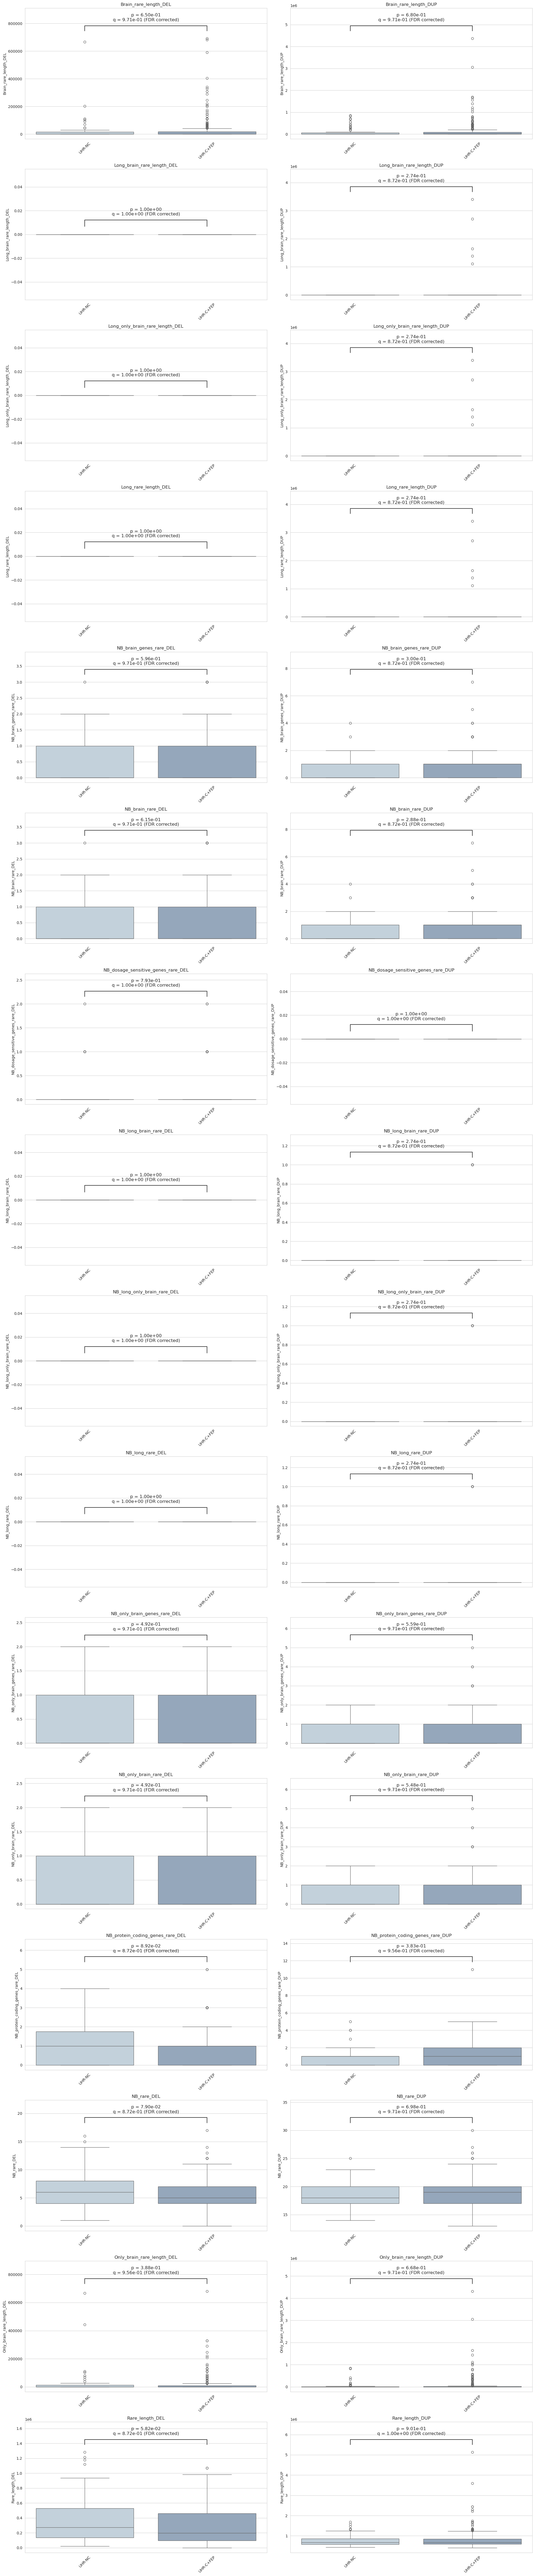

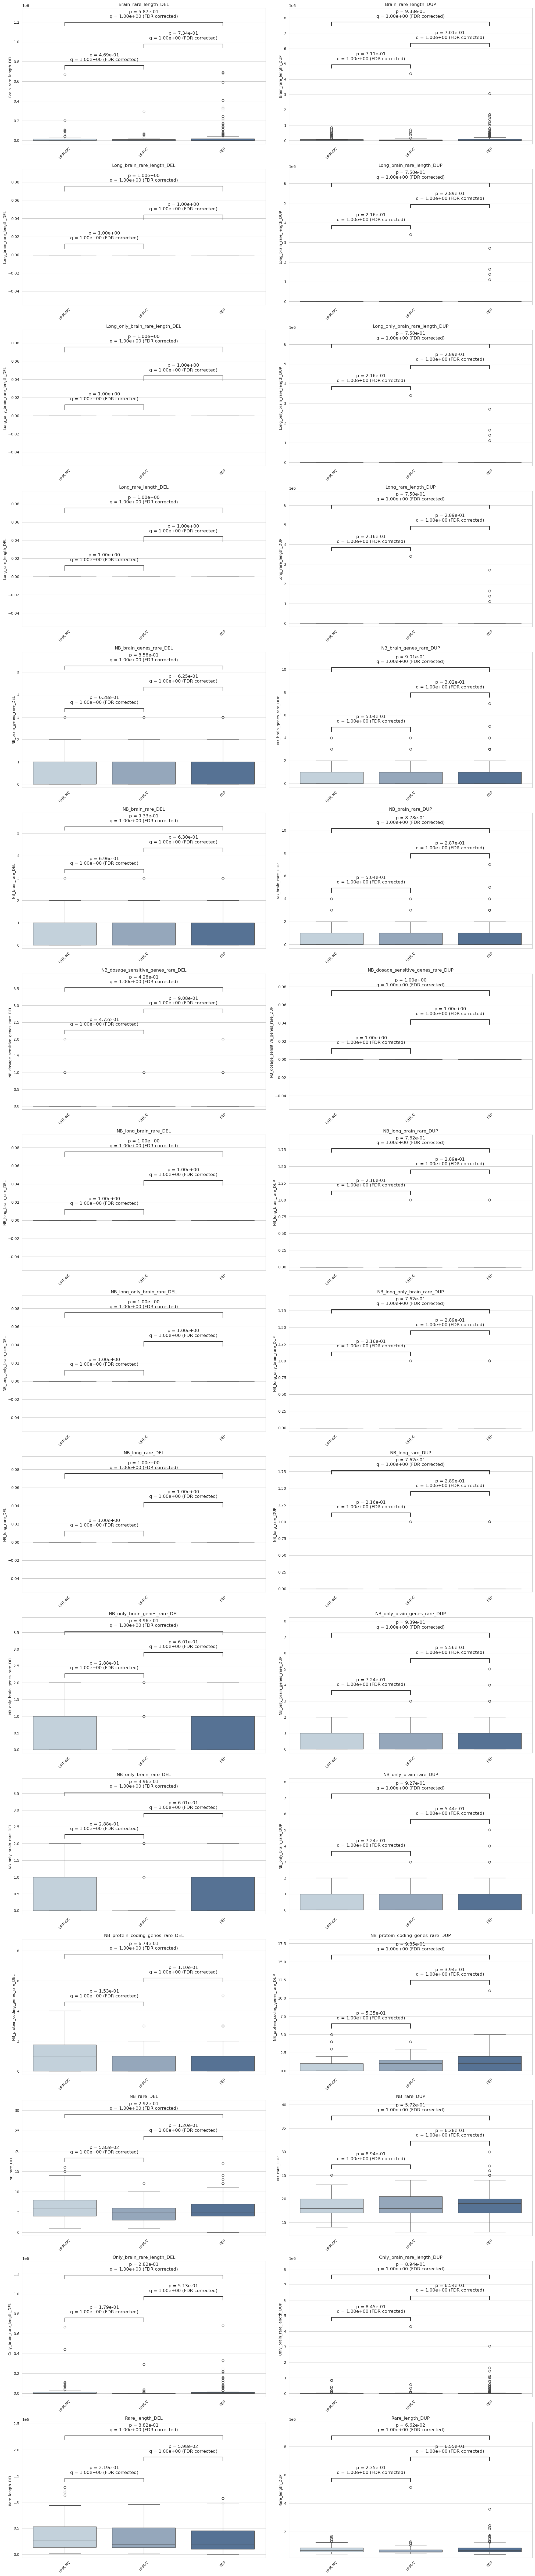

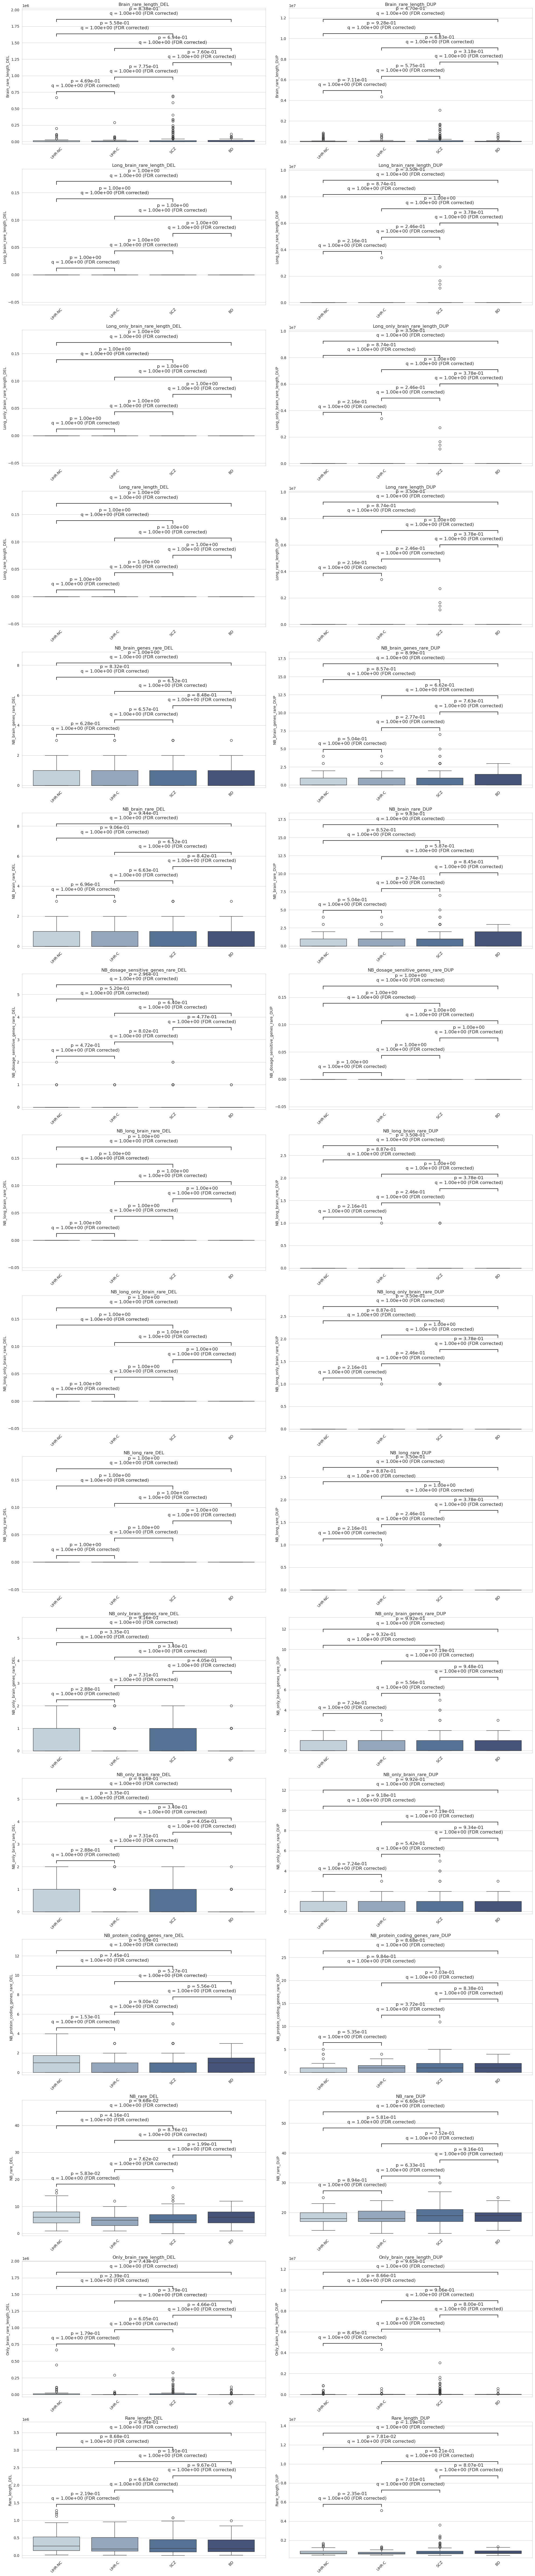

In [6]:
# Non-converters vs. Converters
phenotypes = ["UHR-NC", "UHR-C+FEP"]
df_filtered = filter_df(df, phenotypes)
pairs = [("UHR-NC", "UHR-C+FEP")]
pval_dict = compute_pvalues(df_filtered, pairs)
create_plots(df_filtered, phenotypes, pairs, pval_dict)

# Non-converters vs. Converters vs. First Episode Psychosis
phenotypes = ["UHR-NC", "UHR-C", "FEP"]
df_filtered = filter_df(df, phenotypes)
pairs = [("UHR-NC", "UHR-C"), ("UHR-NC", "FEP"), ("UHR-C", "FEP")]
pval_dict = compute_pvalues(df_filtered, pairs)
create_plots(df_filtered, phenotypes, pairs, pval_dict)

# Non-converters vs. Converters vs. Schizophrenia vs. Bipolar Disorder
phenotypes = ["UHR-NC", "UHR-C", "SCZ", "BD"]
df_filtered = filter_df(df, phenotypes)
pairs = [
    ("UHR-NC", "UHR-C"), ("UHR-NC", "SCZ"), 
    ("UHR-NC", "BD"), ("UHR-C", "SCZ"), 
    ("UHR-C", "BD"), ("SCZ", "BD")
]
pval_dict = compute_pvalues(df_filtered, pairs)
create_plots(df_filtered, phenotypes, pairs, pval_dict)

The group comparison didn't reveal any significant differences (after correcting for multiple testing) between converters and non-converters. This outcome suggests that the CNV parameters used in this analysis do not effectively differentiate between these two groups. However, it is important to note that the sample size was relatively small, which may have limited the ability to detect significant differences.

In [7]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

DESCRIPTOR_DESCRIPTIONS = {
    "Brain_rare_length": "Sum length of all brain-related rare CNVs per individual",
    "Long_brain_rare_length": "Sum length of all long brain-related rare CNVs per individual",
    "Long_only_brain_rare_length": "Sum length of all long only-brain rare CNVs per individual",
    "Long_rare_length": "Sum length of all long rare CNVs per individual",
    "NB_brain_genes_rare": "Number of brain-expressed genes in rare CNVs per individual",
    "NB_brain_rare": "Number of brain-related rare CNVs per individual",
    "NB_dosage_sensitive_genes_rare": "Number of dosage-sensitive genes in rare CNVs per individual",
    "NB_long_brain_rare": "Number of long brain-related rare CNVs per individual",
    "NB_long_only_brain_rare": "Number of long only-brain rare CNVs per individual",
    "NB_long_rare": "Number of long rare CNVs per individual",
    "NB_only_brain_genes_rare": "Number of only-brain genes in rare CNVs per individual",
    "NB_only_brain_rare": "Number of only-brain rare CNVs per individual",
    "NB_protein_coding_genes_rare": "Number of protein-coding genes in rare CNVs per individual",
    "NB_rare": "Number of rare CNVs per individual",
    "Only_brain_rare_length": "Sum length of all only-brain rare CNVs per individual",
    "Rare_length": "Sum length of all rare CNVs per individual",
}

DEL_SUFFIX = "_DEL"
DUP_SUFFIX = "_DUP"

def _base_name(desc: str) -> str:
    return re.sub(r"(_DEL|_DUP)$", "", desc)

def _format_p(val: float) -> str:
    try:
        return f"{float(val):.4f}"
    except Exception:
        return ""

def _direction(group1_vals, group2_vals, g1_name="UHRnc", g2_name="UHRc+FEP") -> str:
    m1 = float(np.nanmedian(group1_vals)) if len(group1_vals) else np.nan
    m2 = float(np.nanmedian(group2_vals)) if len(group2_vals) else np.nan
    if np.isnan(m1) or np.isnan(m2):
        return ""
    if m1 > m2:
        return f"{g1_name} > {g2_name}"
    elif m1 < m2:
        return f"{g1_name} < {g2_name}"
    else:
        return f"{g1_name} = {g2_name}"

def create_summary_table_csv(
    df, phenotypes, pairs, pval_dict,
    out_path="comparison_table.csv",
    comparison_col_title="Comparison",
    p_col_title="p-value of the comparison between UHRnc and UHRc+FEP (DEL, DUP)",
    q_col_title="FDR corrected p-value (DEL, DUP)",
    dir_col_title="Direction of the difference (DEL, DUP)"
):
    if not pairs:
        raise ValueError("pairs is empty. Provide at least one comparison pair.")
    pair = pairs[0]
    g1, g2 = pair
    g1_name, g2_name = g1, g2

    bases = {}
    for desc in DESCRIPTORS:
        base = _base_name(desc)
        bases.setdefault(base, {"DEL": None, "DUP": None})
        if desc.endswith(DEL_SUFFIX):
            bases[base]["DEL"] = desc
        elif desc.endswith(DUP_SUFFIX):
            bases[base]["DUP"] = desc

    rows = []
    for base, dd in bases.items():
        desc_del = dd.get("DEL")
        desc_dup = dd.get("DUP")

        p_del = q_del = p_dup = q_dup = ""
        if desc_del and (desc_del, pair) in pval_dict:
            raw, corr = pval_dict[(desc_del, pair)]
            p_del, q_del = _format_p(raw), _format_p(corr)
        if desc_dup and (desc_dup, pair) in pval_dict:
            raw, corr = pval_dict[(desc_dup, pair)]
            p_dup, q_dup = _format_p(raw), _format_p(corr)

        dir_del = dir_dup = ""
        if desc_del:
            dir_del = _direction(
                df[df["Phenotype"] == g1][desc_del].values,
                df[df["Phenotype"] == g2][desc_del].values,
                g1_name, g2_name
            )
        if desc_dup:
            dir_dup = _direction(
                df[df["Phenotype"] == g1][desc_dup].values,
                df[df["Phenotype"] == g2][desc_dup].values,
                g1_name, g2_name
            )

        comparison_text = DESCRIPTOR_DESCRIPTIONS.get(
            base, f"{base.replace('_', ' ')} (DEL/DUP)"
        )
        rows.append({
            comparison_col_title: comparison_text,
            p_col_title: f"{p_del} (DEL), {p_dup} (DUP)",
            q_col_title: f"{q_del} (DEL), {q_dup} (DUP)",
            dir_col_title: f"{dir_del} (DEL), {dir_dup} (DUP)",
        })

    seen = {}
    order = []
    for d in DESCRIPTORS:
        b = _base_name(d)
        if b not in seen:
            seen[b] = True
            order.append(b)

    def key_func(r):
        inv = {v: k for k, v in DESCRIPTOR_DESCRIPTIONS.items()}
        base = inv.get(r[comparison_col_title], r[comparison_col_title].replace(" (DEL/DUP)","").replace(" ","_"))
        return order.index(base) if base in order else 10**9

    rows.sort(key=key_func)
    table = pd.DataFrame(rows)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    table.to_csv(out_path, index=False)
    return table, str(out_path)


phenotypes = ["UHR-NC", "UHR-C+FEP"]
df_filtered = filter_df(df, phenotypes)
pairs = [("UHR-NC", "UHR-C+FEP")]
pval_dict = compute_pvalues(df_filtered, pairs)
summary_df, csv_path = create_summary_table_csv(
    df=df_filtered,
    phenotypes=phenotypes,
    pairs=pairs,
    pval_dict=pval_dict,
    out_path="../graphs/comparison_table.csv"
)

In [13]:
import pandas as pd

pd.read_csv("../graphs/comparison_table.csv", index_col=0)

p-value of the comparison between UHRnc and UHRc+FEP (DEL, DUP)  \
Comparison                                                                                                           
Sum length of all brain-related rare CNVs per i...                         0.6504 (DEL), 0.6802 (DUP)                
Sum length of all long brain-related rare CNVs ...                         1.0000 (DEL), 0.2742 (DUP)                
Sum length of all long only-brain rare CNVs per...                         1.0000 (DEL), 0.2742 (DUP)                
Sum length of all long rare CNVs per individual                            1.0000 (DEL), 0.2742 (DUP)                
Number of brain-expressed genes in rare CNVs pe...                         0.5964 (DEL), 0.2999 (DUP)                
Number of brain-related rare CNVs per individual                           0.6151 (DEL), 0.2876 (DUP)                
Number of dosage-sensitive genes in rare CNVs p...                         0.7935 (DEL), 1.0000 (DUP)                
Number of long brain-related rare CNVs per indi...                         1.0000 (DEL), 0.2742 (DUP)                
Number of long only-brain rare CNVs per individual                         1.0000 (DEL), 0.2742 (DUP)                
Number of long rare CNVs per individual                                    1.0000 (DEL), 0.2742 (DUP)                
Number of only-brain genes in rare CNVs per ind...                         0.4922 (DEL), 0.5586 (DUP)                
Number of only-brain rare CNVs per individual                              0.4922 (DEL), 0.5482 (DUP)                
Number of protein-coding genes in rare CNVs per...                         0.0892 (DEL), 0.3835 (DUP)                
Number of rare CNVs per individual                                         0.0790 (DEL), 0.6978 (DUP)                
Sum length of all only-brain rare CNVs per indi...                         0.3883 (DEL), 0.6676 (DUP)                
Sum length of all rare CNVs per individual                                 0.0582 (DEL), 0.9006 (DUP)                

                                                   FDR corrected p-value (DEL, DUP)  \
Comparison                                                                            
Sum length of all brain-related rare CNVs per i...       0.9708 (DEL), 0.9708 (DUP)   
Sum length of all long brain-related rare CNVs ...       1.0000 (DEL), 0.8723 (DUP)   
Sum length of all long only-brain rare CNVs per...       1.0000 (DEL), 0.8723 (DUP)   
Sum length of all long rare CNVs per individual          1.0000 (DEL), 0.8723 (DUP)   
Number of brain-expressed genes in rare CNVs pe...       0.9708 (DEL), 0.8723 (DUP)   
Number of brain-related rare CNVs per individual         0.9708 (DEL), 0.8723 (DUP)   
Number of dosage-sensitive genes in rare CNVs p...       1.0000 (DEL), 1.0000 (DUP)   
Number of long brain-related rare CNVs per indi...       1.0000 (DEL), 0.8723 (DUP)   
Number of long only-brain rare CNVs per individual       1.0000 (DEL), 0.8723 (DUP)   
Number of long rare CNVs per individual                  1.0000 (DEL), 0.8723 (DUP)   
Number of only-brain genes in rare CNVs per ind...       0.9708 (DEL), 0.9708 (DUP)   
Number of only-brain rare CNVs per individual            0.9708 (DEL), 0.9708 (DUP)   
Number of protein-coding genes in rare CNVs per...       0.8723 (DEL), 0.9558 (DUP)   
Number of rare CNVs per individual                       0.8723 (DEL), 0.9708 (DUP)   
Sum length of all only-brain rare CNVs per indi...       0.9558 (DEL), 0.9708 (DUP)   
Sum length of all rare CNVs per individual               0.8723 (DEL), 1.0000 (DUP)   

                                                               Direction of the difference (DEL, DUP)  
Comparison                                                                                             
Sum length of all brain-related rare CNVs per i...  UHR-NC = UHR-C+FEP (DEL), UHR-NC < UHR-C+FEP (...  
Sum length of all long brain-related rare CNVs 